# Loading preprocessed data

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K
from time import time
from models import ResNet
from collections import Counter
import matplotlib.pyplot as plt
import os
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix   
import wave
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20,7)

2022-04-14 17:28:23.560801: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# temporarely unused
def load_wave(filename):
   # Read file to get buffer                                                                                               
   ifile = wave.open(filename)
   samples = ifile.getnframes()
   audio = ifile.readframes(samples)

   # Convert buffer to float32 using NumPy                                                                                 
   audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
   audio_as_np_float32 = audio_as_np_int16.astype(np.float32)

   # Normalise float32 array so that values are between -1.0 and +1.0                                                      
   max_int16 = 2**15
   audio_normalised = audio_as_np_float32 / max_int16
   return audio_normalised

### import training and validation data (not included in repo)

In [3]:
X_train = np.load('data/X_train.npy')
Y_train = np.load('data/Y_train.npy')
X_val = np.load('data/X_val.npy')
Y_val = np.load('data/Y_val.npy')

In [4]:
classes = ['yes', 'no', 
           'up', 'down', 
           'left', 'right', 
           'on', 'off', 
           'stop', 'go', 
           'silence', 'unknown']
all_classes = [x for x in classes[:11]]
for ind, cl in enumerate(os.listdir('data/train/audio/')):
    if cl not in classes:
        all_classes.append(cl)
print(all_classes)

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'bird', 'bed', 'house', 'seven', 'six', 'nine', 'dog', 'two', 'eight', 'four', 'tree', 'zero', 'marvin', 'happy', 'sheila', 'wow', 'three', 'one', 'cat', 'five']


In [5]:
# for label in all_classes:
#    print(data[label].shape, ':)')

### The training data is very unbalanced with a much larger 'unknown' class. Keras has a class_weight paramter in the fit() function that will give higher penalties to missclassifications in underrepresented classes. It takes a dict like this:

In [6]:
def get_class_weights(y):
   counter = Counter(y)
   majority = max(counter.values())
   return  {cls: float(majority/count) for cls, count in counter.items()}  

class_weights = get_class_weights(Y_train)


In [7]:
class_weights

{11: 1.0,
 0: 17.399810964083176,
 3: 17.574224343675418,
 10: 101.98891966759003,
 1: 17.490736342042755,
 5: 17.441023211747986,
 9: 17.432765151515152,
 2: 17.4080378250591,
 6: 17.449289099526066,
 8: 17.253045923149017,
 4: 17.482431149097817,
 7: 17.52403617325083}

some constants we need for all models

In [8]:
input_size = X_train.shape[1:]
batch_size = 196

## The ResNet
### declare filters for each block of blocks and set output size.

In [9]:
filters_list = [8,16,32]
output_size = 12

In [10]:
#adjust these strings for organizeing the saved files
date = '20220409'
arch = 'resnet8_16_32'

### Build the model

In [11]:
sr = ResNet(filters_list, input_size, output_size)
sr.build()
sr.m.compile(loss='categorical_crossentropy', 
             optimizer='adadelta', 
             metrics=['accuracy'])

2022-04-14 17:28:31.939053: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-04-14 17:28:31.980798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 17:28:31.980913: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.2GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2022-04-14 17:28:31.980929: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-04-14 17:28:32.029456: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-04-14 17:28:32.029527: I tensorflow/stream_executor/platf

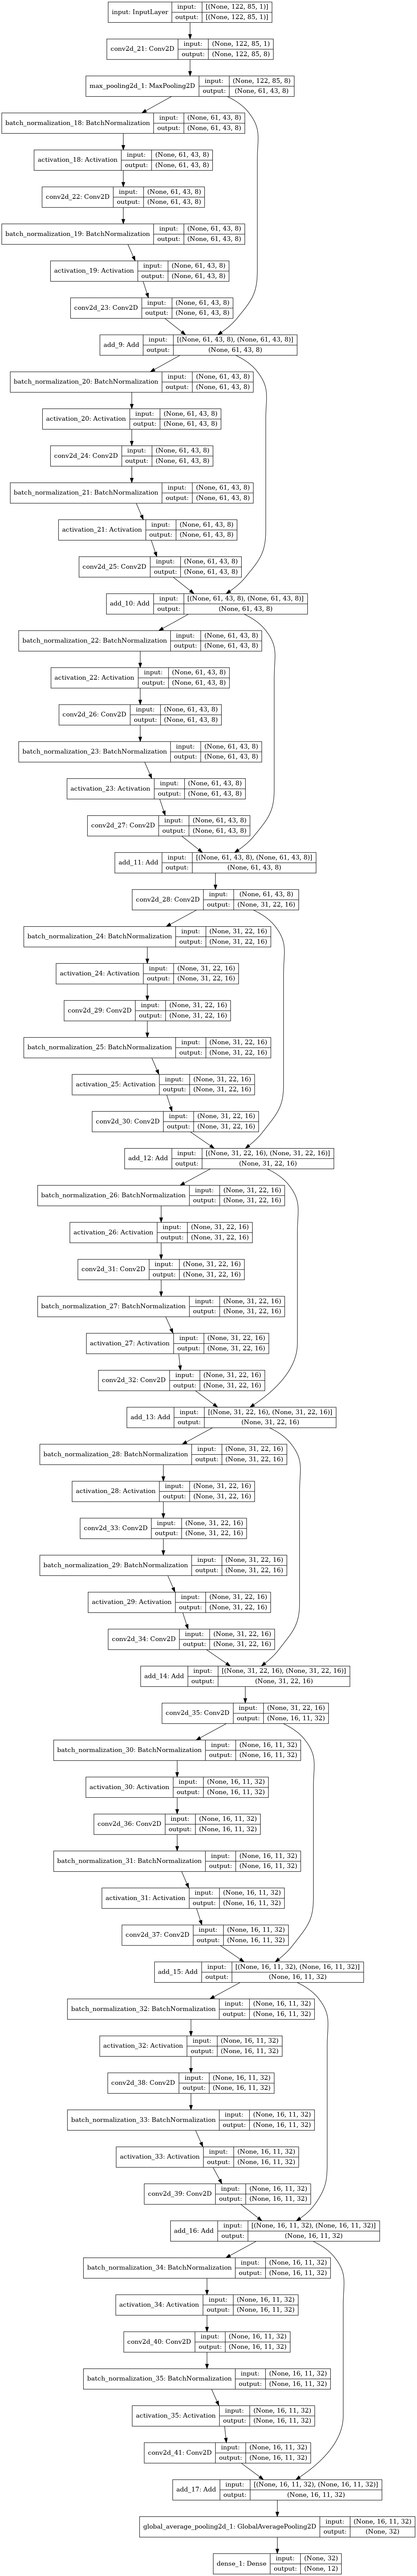

In [27]:
# to save a png of the model you need pydot and graphviz installed
plot_model(sr.m, 
           to_file = './models/{}_{}.png'.format(arch,date), 
           show_shapes = True)

In [12]:
#callbacks, remember to make folders to store files 
checkpointer = ModelCheckpoint(filepath='./models/{}_{}_best.h5'.format(arch, date),
                               verbose=0,
                               save_best_only=True)
   
earlystopping = EarlyStopping()

tensorboard = TensorBoard(log_dir = './logs/{}_{}'.format(date, time()), 
                          histogram_freq = 0, 
                          write_graph = True, 
                          write_images = True)

2022-04-14 17:28:37.051335: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-04-14 17:28:37.051351: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-04-14 17:28:37.051649: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2022-04-14 17:28:37.058488: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so.11.2
2022-04-14 17:28:37.188640: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-04-14 17:28:37.190165: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


### Train the model. The history object stores training data for later access, like plotting training curves

In [13]:
history = sr.m.fit(X_train, 
                   to_categorical(Y_train), 
                   batch_size = batch_size, 
                   epochs = 1, 
                   verbose = 1, shuffle = True, 
                   class_weight = class_weights,
                   validation_data = (X_val, to_categorical(Y_val)), 
                   callbacks = [checkpointer, tensorboard]) # add more callbacks if you want

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2022-04-14 17:28:42.059495: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2417620320 exceeds 10% of free system memory.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-04-14 17:28:43.781196: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-14 17:28:43.808702: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2599990000 Hz
2022-04-14 17:28:45.696668: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-04-14 17:28:46.612469: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2022-04-14 17:28:47.722251: I tensorflow/stream_ex

  1/298 [..............................] - ETA: 28:06 - loss: 24.3749 - accuracy: 0.0612

2022-04-14 17:28:49.613120: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-04-14 17:28:49.613134: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  2/298 [..............................] - ETA: 2:46 - loss: 21.9791 - accuracy: 0.0536 

2022-04-14 17:28:50.139766: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-14 17:28:50.141797: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2022-04-14 17:28:50.190424: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 738 callback api events and 735 activity events. 
2022-04-14 17:28:50.214433: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-04-14 17:28:50.232849: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs/20220409_1649957317.0497088/train/plugins/profile/2022_04_14_17_28_50
2022-04-14 17:28:50.254327: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./logs/20220409_1649957317.0497088/train/plugins/profile/2022_04_14_17_28_50/pc.trace.json.gz
2022-04-14 17:28:50.291536: I tensorflow/core/profiler/rpc/client/save_pr

298/298 [==============================] - 29s 77ms/step - loss: 20.0341 - accuracy: 0.0368 - val_loss: 2.5516 - val_accuracy: 0.0405


In [16]:
sr.m.save_weights("./models/{}_{}_last.h5".format(arch, date)) 


### Plot the training graphs, and save them

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


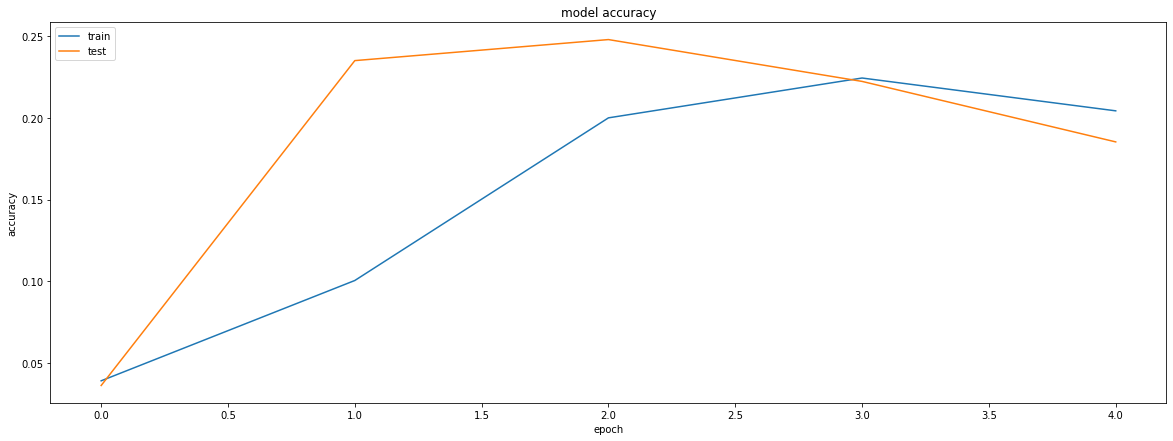

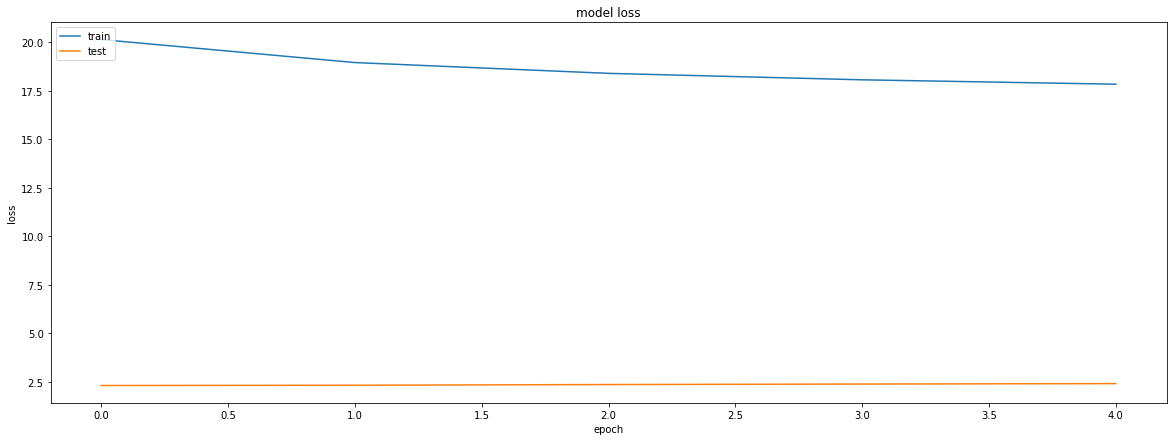

In [19]:
#%% visualize training
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_acc.png'.format(arch, date),bbox_inches='tight')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_loss.png'.format(arch, date), bbox_inches='tight')
plt.show()

### Predict the validation classification and score

In [14]:
val_pred = sr.m.predict(X_val, batch_size = batch_size, verbose = 1)

35/35 [==============================] - 1s 17ms/step


In [15]:
print(classification_report(Y_val, np.argmax(val_pred, axis = 1), target_names = classes, digits = 3))

              precision    recall  f1-score   support

         yes      0.000     0.000     0.000       261
          no      0.000     0.000     0.000       270
          up      0.000     0.000     0.000       260
        down      0.041     0.981     0.079       264
        left      0.000     0.000     0.000       247
       right      0.000     0.000     0.000       256
          on      0.000     0.000     0.000       257
         off      0.000     0.000     0.000       256
        stop      0.000     0.000     0.000       246
          go      0.031     0.069     0.043       260
     silence      0.000     0.000     0.000        41
     unknown      0.000     0.000     0.000      4221

    accuracy                          0.041      6839
   macro avg      0.006     0.088     0.010      6839
weighted avg      0.003     0.041     0.005      6839



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
print(confusion_matrix(Y_val, np.argmax(val_pred, axis = 1)))

[[   0    0    0  199    0    0    0    0    0   62    0    0]
 [   0    0    0  262    0    0    0    0    0    8    0    0]
 [   0    0    0  227    0    0    0    0    0   33    0    0]
 [   0    0    0  259    0    0    0    0    0    5    0    0]
 [   0    0    0  228    0    0    0    0    0   19    0    0]
 [   0    0    0  246    0    0    0    0    0   10    0    0]
 [   0    0    0  244    0    0    0    0    0   13    0    0]
 [   0    0    0  239    0    0    0    0    0   17    0    0]
 [   0    0    0  204    0    0    0    0    0   42    0    0]
 [   0    0    0  242    0    0    0    0    0   18    0    0]
 [   0    0    0   41    0    0    0    0    0    0    0    0]
 [   0    0    0 3865    0    0    0    0    0  356    0    0]]


In [17]:
plt.figure(figsize = (8,8))
plt.imshow(confusion_matrix(Y_val, np.argmax(val_pred, axis = 1), labels = classes))
plt.xticks(np.arange(0, len(classes)), classes, rotation = 'vertical', size = 12)
plt.yticks(np.arange(0, len(classes)), classes, size = 12)
plt.show()

ValueError: At least one label specified must be in y_true

<Figure size 576x576 with 0 Axes>